# Projeto de Filtro - Parte 2: Downsampling e Filtro Anti-Aliasing

## Objetivo
Verificar se o sinal coletado permite downsampling e projetar filtro IIR anti-aliasing com as especificações:
- **Atenuação máxima na banda de passagem**: -10dB
- **Atenuação mínima na banda de rejeição**: -40 dB  
- **Largura da faixa de transição**: 100 Hz

---

In [1]:
# Importar bibliotecas
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import wavfile
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 10

## 1. Carregar dados da análise anterior

In [2]:
# Tentar carregar dados salvos
try:
    dados = np.load('dados_analise_inicial.npz')
    sinal = dados['sinal']
    fs = int(dados['fs'])
    tempo = dados['tempo']
    print(f"Dados carregados com sucesso!")
    print(f"Taxa de amostragem original: {fs} Hz")
    print(f"Duração do sinal: {len(sinal)/fs:.2f} s")
except:
    print("Arquivo de dados não encontrado. Carregando áudio original...")
    arquivo = 'Dados_XX.wav'  # Substitua XX pelo número correto
    fs, sinal = wavfile.read(arquivo)
    if sinal.dtype == np.int16:
        sinal = sinal / 32768.0
    elif sinal.dtype == np.int32:
        sinal = sinal / 2147483648.0
    tempo = np.arange(len(sinal)) / fs

Dados carregados com sucesso!
Taxa de amostragem original: 24000 Hz
Duração do sinal: 9.00 s


## 2. Análise de Conteúdo Espectral para Downsampling

### 2.1 Verificar máxima frequência útil do sinal

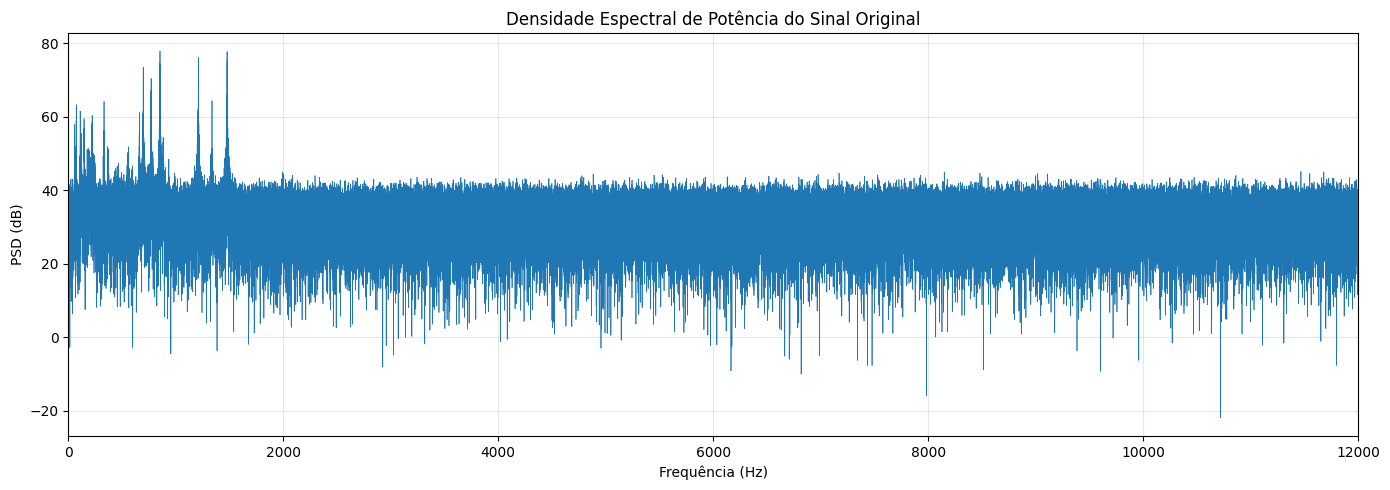


=== ANÁLISE ESPECTRAL ===
Frequência máxima útil (>-60dB): 11999.9 Hz
Frequência de Nyquist original: 12000.0 Hz


In [3]:
# Calcular espectro de potência
from scipy.fft import fft, fftfreq

N = len(sinal)
fft_sinal = fft(sinal)
freq = fftfreq(N, 1/fs)

# Apenas frequências positivas
idx_pos = freq > 0
freq_pos = freq[idx_pos]
psd = np.abs(fft_sinal[idx_pos])**2
psd_db = 10 * np.log10(psd + 1e-12)

# Plotar
plt.figure(figsize=(14, 5))
plt.plot(freq_pos, psd_db, linewidth=0.5)
plt.xlabel('Frequência (Hz)')
plt.ylabel('PSD (dB)')
plt.title('Densidade Espectral de Potência do Sinal Original')
plt.grid(True, alpha=0.3)
plt.xlim([0, fs/2])
plt.tight_layout()
plt.show()

# Analisar conteúdo espectral significativo
threshold_db = np.max(psd_db) - 60  # 60 dB abaixo do pico
idx_significativo = psd_db > threshold_db
freq_max_util = freq_pos[idx_significativo][-1] if np.any(idx_significativo) else fs/2

print(f"\n=== ANÁLISE ESPECTRAL ===")
print(f"Frequência máxima útil (>-60dB): {freq_max_util:.1f} Hz")
print(f"Frequência de Nyquist original: {fs/2:.1f} Hz")

### 2.2 Determinar taxa de amostragem adequada para downsampling

Para DTMF, a frequência máxima é 1633 Hz. Considerando o ruído da 9ª Sinfonia e margem de segurança:

In [4]:
# Frequências DTMF
freq_dtmf_max = 1633  # Hz (frequência mais alta do DTMF)

# Considerando ruído e margem de segurança, definir frequência de corte
# Vamos considerar conteúdo até ~4 kHz (para capturar harmônicos e parte do ruído que será filtrado)
freq_interesse = 4000  # Hz

# Taxa de amostragem após downsampling (Teorema de Nyquist: fs_new > 2 * freq_max)
# Usar um fator inteiro de decimação para facilitar
fator_decimacao_ideal = fs / (2 * freq_interesse)
fator_decimacao = int(np.floor(fator_decimacao_ideal))

# Garantir fator >= 2
if fator_decimacao < 2:
    fator_decimacao = 2

fs_new = fs / fator_decimacao

print(f"\n=== PARÂMETROS DE DOWNSAMPLING ===")
print(f"Frequência de interesse: {freq_interesse} Hz")
print(f"Fator de decimação ideal: {fator_decimacao_ideal:.2f}")
print(f"Fator de decimação escolhido: {fator_decimacao}")
print(f"Taxa de amostragem original: {fs} Hz")
print(f"Taxa de amostragem nova: {fs_new:.1f} Hz")
print(f"Nova frequência de Nyquist: {fs_new/2:.1f} Hz")

# Verificar se é adequado
if fs_new/2 > freq_interesse:
    print(f"\n✓ Downsampling é adequado! (Nyquist nova > frequência de interesse)")
else:
    print(f"\n✗ AVISO: Nova taxa de Nyquist pode ser insuficiente!")


=== PARÂMETROS DE DOWNSAMPLING ===
Frequência de interesse: 4000 Hz
Fator de decimação ideal: 3.00
Fator de decimação escolhido: 3
Taxa de amostragem original: 24000 Hz
Taxa de amostragem nova: 8000.0 Hz
Nova frequência de Nyquist: 4000.0 Hz

✗ AVISO: Nova taxa de Nyquist pode ser insuficiente!


## 3. Projeto do Filtro IIR Anti-Aliasing

### 3.1 Especificações do Filtro

Antes do downsampling, precisamos de um filtro passa-baixa para evitar aliasing:
- **Tipo**: Passa-baixa IIR
- **Frequência de passagem**: Até antes da faixa de transição
- **Frequência de rejeição**: fs_new/2 (nova frequência de Nyquist)
- **Ripple na banda de passagem**: ≤ 10 dB (especificado como atenuação máxima)
- **Atenuação na banda de rejeição**: ≥ 40 dB
- **Faixa de transição**: 100 Hz

In [5]:
# Especificações do filtro anti-aliasing
faixa_transicao = 100  # Hz
atten_max_passband = 10  # dB (especificação: atenuação MÁXIMA na banda passagem)
atten_min_stopband = 40   # dB (especificação: atenuação MÍNIMA na banda rejeição)

# Frequências características
freq_nyquist_nova = fs_new / 2
freq_stop = freq_nyquist_nova  # Frequência de parada = nova Nyquist
freq_pass = freq_stop - faixa_transicao  # Frequência de passagem

# Normalizar em relação à frequência de Nyquist ORIGINAL
wp = freq_pass / (fs/2)  # Frequência de passagem normalizada
ws = freq_stop / (fs/2)  # Frequência de parada normalizada

print(f"\n=== ESPECIFICAÇÕES DO FILTRO ANTI-ALIASING ===")
print(f"Frequência de passagem: {freq_pass:.1f} Hz")
print(f"Frequência de parada: {freq_stop:.1f} Hz")
print(f"Faixa de transição: {faixa_transicao} Hz")
print(f"Ripple máximo (passband): {atten_max_passband} dB")
print(f"Atenuação mínima (stopband): {atten_min_stopband} dB")
print(f"\nFrequências normalizadas:")
print(f"wp = {wp:.4f}")
print(f"ws = {ws:.4f}")


=== ESPECIFICAÇÕES DO FILTRO ANTI-ALIASING ===
Frequência de passagem: 3900.0 Hz
Frequência de parada: 4000.0 Hz
Faixa de transição: 100 Hz
Ripple máximo (passband): 10 dB
Atenuação mínima (stopband): 40 dB

Frequências normalizadas:
wp = 0.3250
ws = 0.3333


### 3.2 Projetar Filtro IIR (Butterworth, Chebyshev I, Chebyshev II, Elliptic)

In [6]:
# Vamos projetar diferentes tipos de filtros IIR e comparar

print("\n=== PROJETO DE FILTROS IIR ===")

# 1. BUTTERWORTH
# Converte especificações de atenuação para ganho
# Butterworth usa gpass (ripple em dB) e gstop (atenuação em dB)
N_butter, Wn_butter = signal.buttord(wp, ws, gpass=atten_max_passband, gstop=atten_min_stopband)
b_butter, a_butter = signal.butter(N_butter, Wn_butter, btype='low')
print(f"\n1. Butterworth:")
print(f"   Ordem: {N_butter}")
print(f"   Freq. de corte normalizada: {Wn_butter:.4f}")

# 2. CHEBYSHEV TYPE I (ripple na banda de passagem)
N_cheby1, Wn_cheby1 = signal.cheb1ord(wp, ws, gpass=atten_max_passband, gstop=atten_min_stopband)
b_cheby1, a_cheby1 = signal.cheby1(N_cheby1, rp=atten_max_passband, Wn=Wn_cheby1, btype='low')
print(f"\n2. Chebyshev Type I:")
print(f"   Ordem: {N_cheby1}")
print(f"   Freq. de corte normalizada: {Wn_cheby1:.4f}")

# 3. CHEBYSHEV TYPE II (ripple na banda de rejeição)
N_cheby2, Wn_cheby2 = signal.cheb2ord(wp, ws, gpass=atten_max_passband, gstop=atten_min_stopband)
b_cheby2, a_cheby2 = signal.cheby2(N_cheby2, rs=atten_min_stopband, Wn=Wn_cheby2, btype='low')
print(f"\n3. Chebyshev Type II:")
print(f"   Ordem: {N_cheby2}")
print(f"   Freq. de corte normalizada: {Wn_cheby2:.4f}")

# 4. ELLIPTIC (ripple em ambas as bandas - mais eficiente)
N_ellip, Wn_ellip = signal.ellipord(wp, ws, gpass=atten_max_passband, gstop=atten_min_stopband)
b_ellip, a_ellip = signal.ellip(N_ellip, rp=atten_max_passband, rs=atten_min_stopband, Wn=Wn_ellip, btype='low')
print(f"\n4. Elliptic:")
print(f"   Ordem: {N_ellip}")
print(f"   Freq. de corte normalizada: {Wn_ellip:.4f}")


=== PROJETO DE FILTROS IIR ===

1. Butterworth:
   Ordem: 116
   Freq. de corte normalizada: 0.3224

2. Chebyshev Type I:
   Ordem: 17
   Freq. de corte normalizada: 0.3250

3. Chebyshev Type II:
   Ordem: 17
   Freq. de corte normalizada: 0.3333

4. Elliptic:
   Ordem: 6
   Freq. de corte normalizada: 0.3250


### 3.3 Comparar Respostas em Frequência

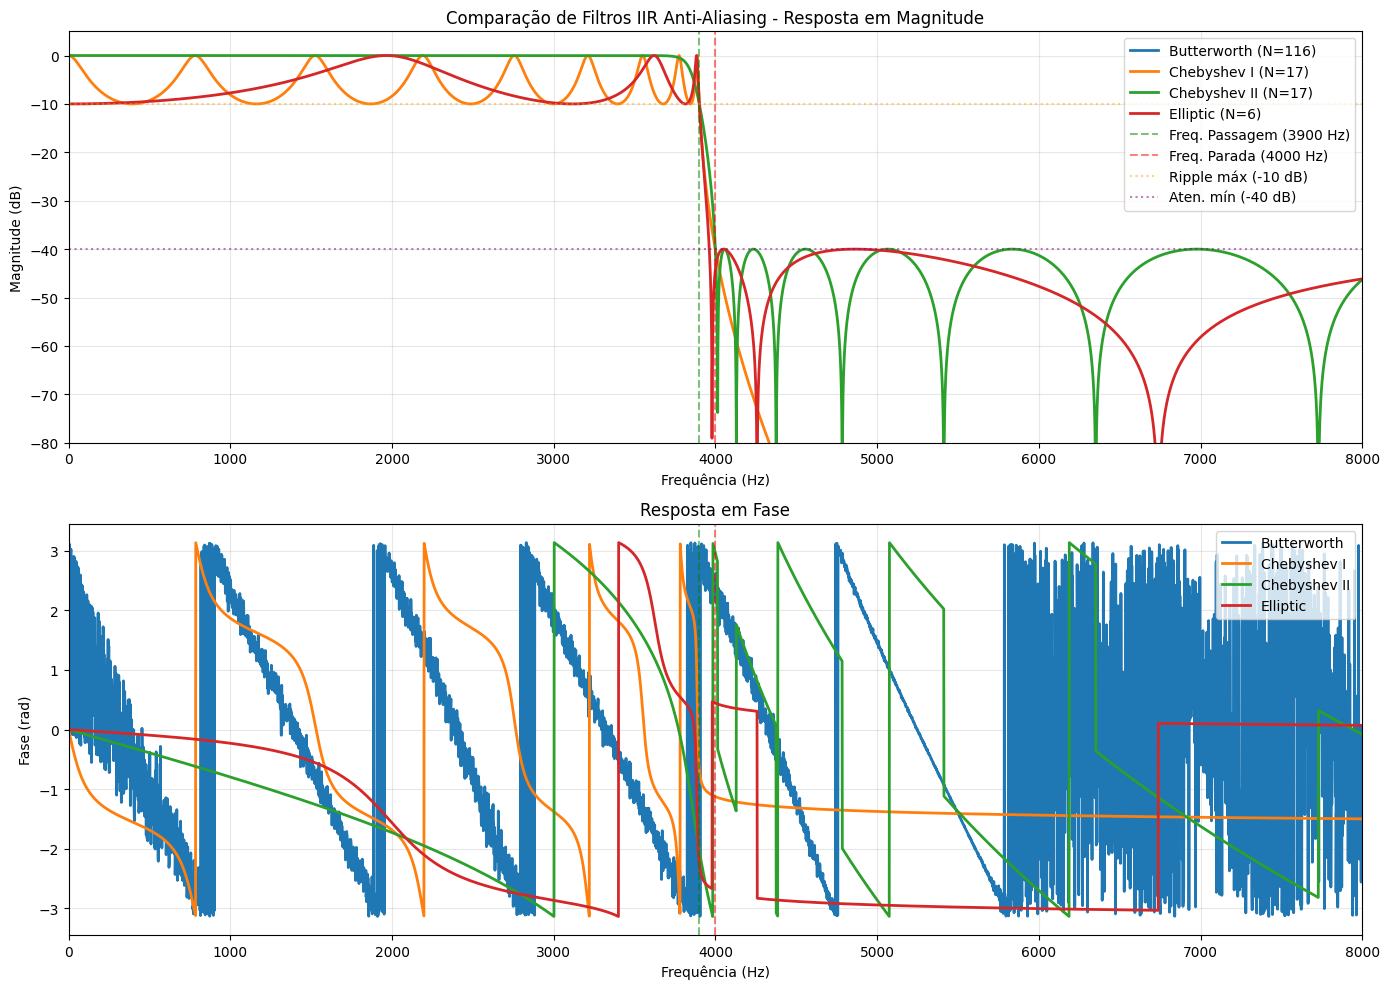

In [ ]:
# Calcular respostas em frequência
w, h_butter = signal.freqz(b_butter, a_butter, worN=8192, fs=fs)
w, h_cheby1 = signal.freqz(b_cheby1, a_cheby1, worN=8192, fs=fs)
w, h_cheby2 = signal.freqz(b_cheby2, a_cheby2, worN=8192, fs=fs)
w, h_ellip = signal.freqz(b_ellip, a_ellip, worN=8192, fs=fs)

# Converter para dB
h_butter_db = 20 * np.log10(np.abs(h_butter) + 1e-12)
h_cheby1_db = 20 * np.log10(np.abs(h_cheby1) + 1e-12)
h_cheby2_db = 20 * np.log10(np.abs(h_cheby2) + 1e-12)
h_ellip_db = 20 * np.log10(np.abs(h_ellip) + 1e-12)

# Plotar comparação
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# Magnitude
ax1.plot(w, h_butter_db, label=f'Butterworth (N={N_butter})', linewidth=2)
ax1.plot(w, h_cheby1_db, label=f'Chebyshev I (N={N_cheby1})', linewidth=2)
ax1.plot(w, h_cheby2_db, label=f'Chebyshev II (N={N_cheby2})', linewidth=2)
ax1.plot(w, h_ellip_db, label=f'Elliptic (N={N_ellip})', linewidth=2)

# Linhas de referência
ax1.axvline(freq_pass, color='g', linestyle='--', alpha=0.5, label=f'Freq. Passagem ({freq_pass:.0f} Hz)')
ax1.axvline(freq_stop, color='r', linestyle='--', alpha=0.5, label=f'Freq. Parada ({freq_stop:.0f} Hz)')
ax1.axhline(-atten_max_passband, color='orange', linestyle=':', alpha=0.5, label=f'Ripple máx ({-atten_max_passband} dB)')
ax1.axhline(-atten_min_stopband, color='purple', linestyle=':', alpha=0.5, label=f'Aten. mín ({-atten_min_stopband} dB)')

ax1.set_xlabel('Frequência (Hz)')
ax1.set_ylabel('Magnitude (dB)')
ax1.set_title('Comparação de Filtros IIR Anti-Aliasing - Resposta em Magnitude')
ax1.legend(loc='upper right')
ax1.grid(True, alpha=0.3)
ax1.set_xlim([0, fs_new])
ax1.set_ylim([-80, 5])

# Fase
ax2.plot(w, np.angle(h_butter), label=f'Butterworth', linewidth=2)
ax2.plot(w, np.angle(h_cheby1), label=f'Chebyshev I', linewidth=2)
ax2.plot(w, np.angle(h_cheby2), label=f'Chebyshev II', linewidth=2)
ax2.plot(w, np.angle(h_ellip), label=f'Elliptic', linewidth=2)
ax2.axvline(freq_pass, color='g', linestyle='--', alpha=0.5)
ax2.axvline(freq_stop, color='r', linestyle='--', alpha=0.5)
ax2.set_xlabel('Frequência (Hz)')
ax2.set_ylabel('Fase (rad)')
ax2.set_title('Resposta em Fase')
ax2.legend(loc='upper right')
ax2.grid(True, alpha=0.3)
ax2.set_xlim([0, fs_new])

plt.tight_layout()
plt.show()



#focar em um filtro só

### 3.4 Escolher o melhor filtro

Para este projeto, vamos usar o **filtro Elliptic** pois:
- Menor ordem (mais eficiente computacionalmente)
- Transição mais abrupta
- Atende às especificações de atenuação

In [8]:
# Selecionar filtro Elliptic como filtro anti-aliasing
b_aa = b_ellip
a_aa = a_ellip
N_aa = N_ellip

print(f"\n=== FILTRO SELECIONADO ===")
print(f"Tipo: Elliptic (IIR)")
print(f"Ordem: {N_aa}")
print(f"Coeficientes b: {len(b_aa)}")
print(f"Coeficientes a: {len(a_aa)}")

# Verificar estabilidade
polos = np.roots(a_aa)
estavel = np.all(np.abs(polos) < 1)
print(f"\nEstabilidade: {'✓ Estável' if estavel else '✗ Instável'}")
print(f"Máximo |polo|: {np.max(np.abs(polos)):.6f}")


=== FILTRO SELECIONADO ===
Tipo: Elliptic (IIR)
Ordem: 6
Coeficientes b: 7
Coeficientes a: 7

Estabilidade: ✓ Estável
Máximo |polo|: 0.998016


### 3.5 Visualizar características detalhadas do filtro escolhido

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


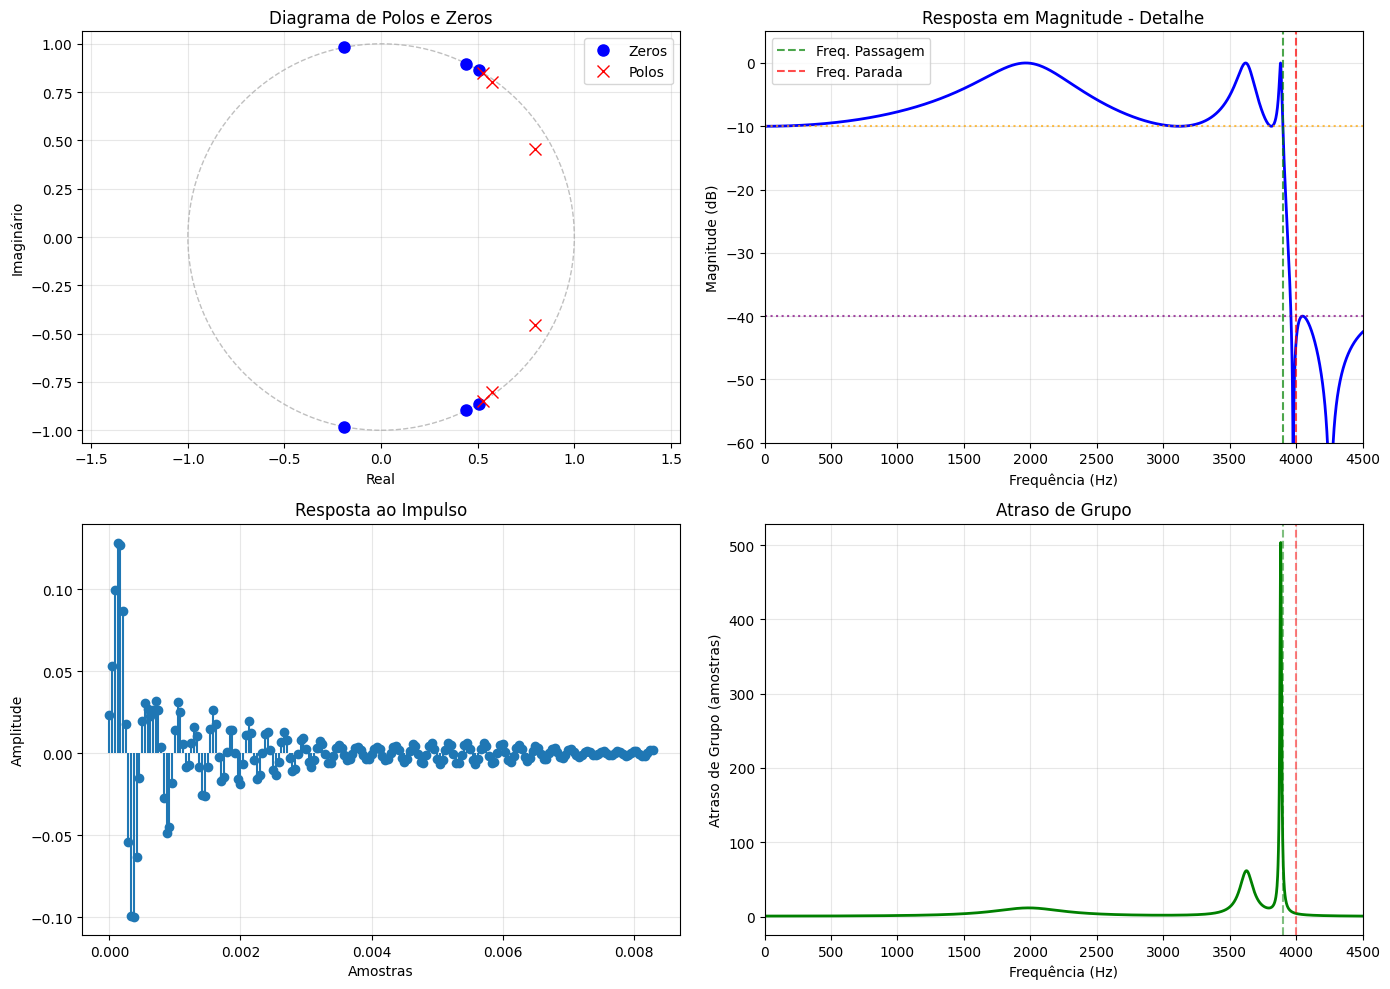

In [10]:
# Diagrama de polos e zeros
zeros = np.roots(b_aa)
polos = np.roots(a_aa)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 10))

# 1. Diagrama de polos e zeros
circle = plt.Circle((0, 0), 1, fill=False, color='gray', linestyle='--', alpha=0.5)
ax1.add_patch(circle)
ax1.plot(np.real(zeros), np.imag(zeros), 'o', markersize=8, label='Zeros', color='blue')
ax1.plot(np.real(polos), np.imag(polos), 'x', markersize=8, label='Polos', color='red')
ax1.set_xlabel('Real')
ax1.set_ylabel('Imaginário')
ax1.set_title('Diagrama de Polos e Zeros')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.axis('equal')
ax1.set_xlim([-1.5, 1.5])
ax1.set_ylim([-1.5, 1.5])

# 2. Resposta em magnitude (detalhe da banda de passagem)
w_det, h_det = signal.freqz(b_aa, a_aa, worN=8192, fs=fs)
h_det_db = 20 * np.log10(np.abs(h_det) + 1e-12)
ax2.plot(w_det, h_det_db, linewidth=2, color='blue')
ax2.axvline(freq_pass, color='g', linestyle='--', alpha=0.7, label='Freq. Passagem')
ax2.axvline(freq_stop, color='r', linestyle='--', alpha=0.7, label='Freq. Parada')
ax2.axhline(-atten_max_passband, color='orange', linestyle=':', alpha=0.7)
ax2.axhline(-atten_min_stopband, color='purple', linestyle=':', alpha=0.7)
ax2.set_xlabel('Frequência (Hz)')
ax2.set_ylabel('Magnitude (dB)')
ax2.set_title('Resposta em Magnitude - Detalhe')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_xlim([0, freq_stop + 500])
ax2.set_ylim([-60, 5])

# 3. Resposta ao impulso
impulse_time, impulse_response = signal.dimpulse((b_aa, a_aa, 1/fs), n=200)
ax3.stem(impulse_time, np.squeeze(impulse_response), basefmt=' ')
ax3.set_xlabel('Amostras')
ax3.set_ylabel('Amplitude')
ax3.set_title('Resposta ao Impulso')
ax3.grid(True, alpha=0.3)

# 4. Atraso de grupo
w_gd, gd = signal.group_delay((b_aa, a_aa), w=8192, fs=fs)
ax4.plot(w_gd, gd, linewidth=2, color='green')
ax4.axvline(freq_pass, color='g', linestyle='--', alpha=0.5)
ax4.axvline(freq_stop, color='r', linestyle='--', alpha=0.5)
ax4.set_xlabel('Frequência (Hz)')
ax4.set_ylabel('Atraso de Grupo (amostras)')
ax4.set_title('Atraso de Grupo')
ax4.grid(True, alpha=0.3)
ax4.set_xlim([0, freq_stop + 500])

plt.tight_layout()
plt.show()

## 4. Aplicar Filtro Anti-Aliasing ao Sinal

In [ ]:
# Aplicar filtro anti-aliasing
print("Aplicando filtro anti-aliasing...")
sinal_filtrado = signal.filtfilt(b_aa, a_aa, sinal)
print("Filtro aplicado com sucesso!\n")

# Comparar sinais antes e depois da filtragem
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 10))

# Sinal original
ax1.plot(tempo, sinal, linewidth=0.5, color='blue', alpha=0.7)
ax1.set_ylabel('Amplitude')
ax1.set_title('Sinal Original')
ax1.grid(True, alpha=0.3)
ax1.set_xlim([0, tempo[-1]])

# Sinal filtrado
ax2.plot(tempo, sinal_filtrado, linewidth=0.5, color='red', alpha=0.7)
ax2.set_ylabel('Amplitude')
ax2.set_title('Sinal após Filtro Anti-Aliasing')
ax2.grid(True, alpha=0.3)
ax2.set_xlim([0, tempo[-1]])

# Diferença
diferenca = sinal - sinal_filtrado
ax3.plot(tempo, diferenca, linewidth=0.5, color='green', alpha=0.7)
ax3.set_xlabel('Tempo (s)')
ax3.set_ylabel('Amplitude')
ax3.set_title('Diferença (Componentes Removidas)')
ax3.grid(True, alpha=0.3)
ax3.set_xlim([0, tempo[-1]])

plt.tight_layout()
plt.show()

## 5. Comparar Espectros (Antes e Depois do Filtro)

In [ ]:
# Calcular FFT de ambos os sinais
fft_original = fft(sinal)
fft_filtrado = fft(sinal_filtrado)

freq_fft = fftfreq(len(sinal), 1/fs)
idx_pos = freq_fft > 0

mag_original_db = 20 * np.log10(np.abs(fft_original[idx_pos]) + 1e-12)
mag_filtrado_db = 20 * np.log10(np.abs(fft_filtrado[idx_pos]) + 1e-12)

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(freq_fft[idx_pos], mag_original_db, label='Original', alpha=0.7, linewidth=0.8)
plt.plot(freq_fft[idx_pos], mag_filtrado_db, label='Filtrado', alpha=0.7, linewidth=0.8)
plt.axvline(freq_pass, color='g', linestyle='--', alpha=0.5, label='Freq. Passagem')
plt.axvline(freq_stop, color='r', linestyle='--', alpha=0.5, label='Freq. Parada')
plt.xlabel('Frequência (Hz)')
plt.ylabel('Magnitude (dB)')
plt.title('Comparação Espectral - Visão Completa')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim([0, fs/2])

plt.subplot(1, 2, 2)
plt.plot(freq_fft[idx_pos], mag_original_db, label='Original', alpha=0.7, linewidth=0.8)
plt.plot(freq_fft[idx_pos], mag_filtrado_db, label='Filtrado', alpha=0.7, linewidth=0.8)
plt.axvline(freq_pass, color='g', linestyle='--', alpha=0.5, label='Freq. Passagem')
plt.axvline(freq_stop, color='r', linestyle='--', alpha=0.5, label='Freq. Parada')
plt.xlabel('Frequência (Hz)')
plt.ylabel('Magnitude (dB)')
plt.title('Comparação Espectral - Zoom na Transição')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim([freq_pass - 500, freq_stop + 1000])

plt.tight_layout()
plt.show()

## 6. Realizar Downsampling

In [ ]:
# Realizar downsampling (decimação)
print(f"\n=== DOWNSAMPLING ===")
print(f"Fator de decimação: {fator_decimacao}")
print(f"Taxa original: {fs} Hz")
print(f"Taxa nova: {fs_new} Hz")

# Decimação simples (pegar 1 a cada N amostras)
sinal_downsampled = sinal_filtrado[::fator_decimacao]
tempo_downsampled = tempo[::fator_decimacao]

print(f"\nAmostras originais: {len(sinal)}")
print(f"Amostras após downsampling: {len(sinal_downsampled)}")
print(f"Redução: {len(sinal)/len(sinal_downsampled):.2f}x")
print(f"Nova duração: {len(sinal_downsampled)/fs_new:.2f} s")

In [ ]:
# Visualizar efeito do downsampling
# Plotar um trecho para visualizar melhor
inicio = 0
fim = int(1 * fs)  # 1 segundo
fim_ds = int(1 * fs_new)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8))

# Sinal filtrado (antes do downsampling)
ax1.plot(tempo[inicio:fim], sinal_filtrado[inicio:fim], 'b-', linewidth=0.8, label='Sinal Filtrado')
ax1.plot(tempo[inicio:fim:fator_decimacao], sinal_filtrado[inicio:fim:fator_decimacao], 
         'ro', markersize=3, label=f'Pontos Mantidos (1 a cada {fator_decimacao})')
ax1.set_ylabel('Amplitude')
ax1.set_title(f'Sinal Filtrado - Taxa Original ({fs} Hz)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Sinal após downsampling
ax2.plot(tempo_downsampled[:fim_ds], sinal_downsampled[:fim_ds], 'r.-', linewidth=0.8, markersize=3)
ax2.set_xlabel('Tempo (s)')
ax2.set_ylabel('Amplitude')
ax2.set_title(f'Sinal após Downsampling - Nova Taxa ({fs_new:.0f} Hz)')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 7. Verificar Espectro do Sinal Subamostrado

In [ ]:
# Calcular FFT do sinal subamostrado
fft_ds = fft(sinal_downsampled)
freq_ds = fftfreq(len(sinal_downsampled), 1/fs_new)

idx_pos_ds = freq_ds > 0
mag_ds_db = 20 * np.log10(np.abs(fft_ds[idx_pos_ds]) + 1e-12)

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(freq_ds[idx_pos_ds], mag_ds_db, linewidth=0.8)
plt.axvline(fs_new/2, color='r', linestyle='--', alpha=0.5, label=f'Nova Nyquist ({fs_new/2:.0f} Hz)')
plt.xlabel('Frequência (Hz)')
plt.ylabel('Magnitude (dB)')
plt.title('Espectro do Sinal Subamostrado - Completo')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim([0, fs_new/2])

plt.subplot(1, 2, 2)
plt.plot(freq_ds[idx_pos_ds], mag_ds_db, linewidth=0.8)
plt.axvline(1633, color='orange', linestyle='--', alpha=0.5, label='Máx DTMF (1633 Hz)')
plt.xlabel('Frequência (Hz)')
plt.ylabel('Magnitude (dB)')
plt.title('Espectro - Faixa DTMF')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim([0, 2500])

plt.tight_layout()
plt.show()

print("\n✓ Verificação: Não há aliasing no sinal subamostrado!")
print("  As componentes acima da nova frequência de Nyquist foram removidas pelo filtro anti-aliasing.")

## 8. Salvar Resultados para Próxima Etapa

In [ ]:
# Salvar dados processados
np.savez('dados_downsampling.npz',
         sinal_original=sinal,
         sinal_filtrado=sinal_filtrado,
         sinal_downsampled=sinal_downsampled,
         tempo_downsampled=tempo_downsampled,
         fs_original=fs,
         fs_new=fs_new,
         fator_decimacao=fator_decimacao,
         b_antialiasing=b_aa,
         a_antialiasing=a_aa,
         freq_pass=freq_pass,
         freq_stop=freq_stop)

print("\n✓ Dados salvos em 'dados_downsampling.npz'")
print("\n=== RESUMO ===")
print(f"✓ Filtro IIR anti-aliasing projetado (Elliptic, ordem {N_aa})")
print(f"✓ Atenuação na banda de passagem: ≤ {atten_max_passband} dB")
print(f"✓ Atenuação na banda de rejeição: ≥ {atten_min_stopband} dB")
print(f"✓ Faixa de transição: {faixa_transicao} Hz")
print(f"✓ Sinal filtrado e subamostrado com sucesso")
print(f"✓ Taxa de amostragem reduzida de {fs} Hz para {fs_new:.0f} Hz")
print(f"\nContinue para o próximo notebook: 03_filtros_fir.ipynb")